<a href="https://colab.research.google.com/github/AbhilashDatta/AbhilashDatta/blob/main/Multi-Person%20Pose%20%20Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mediapipe --q

     |████████████████████████████████| 32.7 MB 1.4 MB/s 


In [2]:
import cv2
import mediapipe as mp
import numpy as np
from google.colab.patches import cv2_imshow

from mediapipe.python.solutions import drawing_utils as mp_drawing
from mediapipe.python.solutions import pose as mp_pose

In [3]:
# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.7.0
The following GPU devices are available: /device:GPU:0


In [4]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" 
detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [16]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def resize_image(image_data, new_width=256, new_height=256,
                              display=False):
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  if display:
    display_image(pil_image)
  return pil_image_rgb


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.02):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [6]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [14]:
def run_detector(detector, path):
  img = load_img(path)
  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  lst1 = []
  lst2 = []
  lst3 = []

  for i,c in enumerate(result["detection_class_entities"]):
    if c==b'Furniture' or c==b'Person':
      lst2.append(result["detection_class_entities"][i])
      lst1.append(result["detection_boxes"][i])
      lst3.append(result["detection_scores"][i])

  pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

  count = 0

  for i,c in enumerate(result["detection_class_entities"]):
    if c==b'Person':
      ymin, xmin, ymax, xmax = result['detection_boxes'][i][0], result['detection_boxes'][i][1], result['detection_boxes'][i][2], result['detection_boxes'][i][3]
      xmin = int(xmin*img.shape[1])
      xmax = int(xmax*img.shape[1])
      ymin = int(ymin*img.shape[0])
      ymax = int(ymax*img.shape[0])

      image = img[ymin:ymax, xmin:xmax, :]
      # Recolor image to RGB
      image = cv2.cvtColor(np.uint8(image), cv2.COLOR_BGR2RGB)
      image.flags.writeable = False
    
      # Make detection
      results = pose.process(image)
      if results.pose_landmarks is not None:
        count+=1
      # Recolor back to BGR
      image.flags.writeable = True
      image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
      
      # Render detections
      mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                              mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                )  
      cv2_imshow(image)

  
  # image_with_boxes = draw_boxes(
  #     img.numpy(), result["detection_boxes"],
  #     result["detection_class_entities"], result["detection_scores"])
  
  img = draw_boxes( img.numpy(), np.array(lst1), np.array(lst2), np.array(lst3))

  # print('People Found ',count)
  display_image(img)

Found 100 objects.
Inference time:  3.1036758422851562


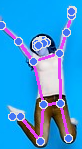

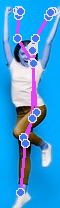

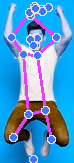

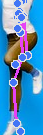

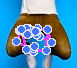

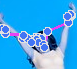

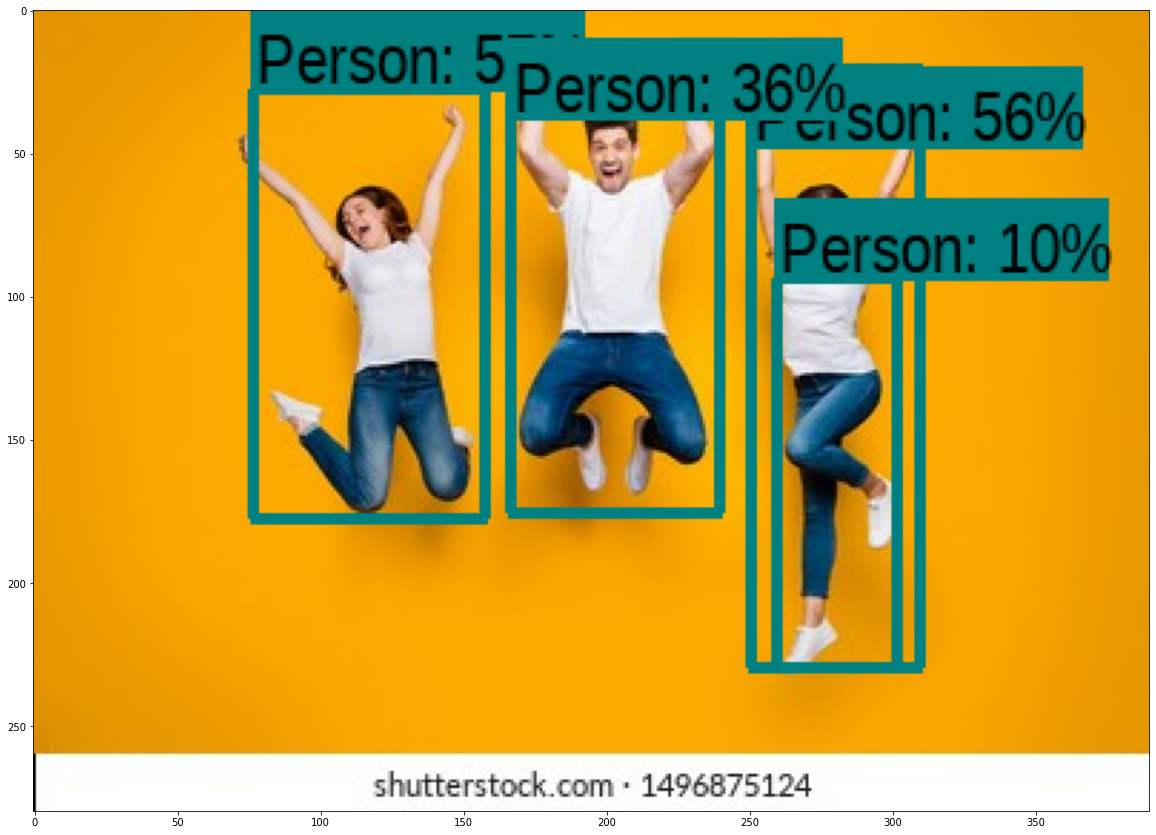

In [19]:
run_detector(detector, '/content/3people.jpg')

Found 100 objects.
Inference time:  6.63786768913269


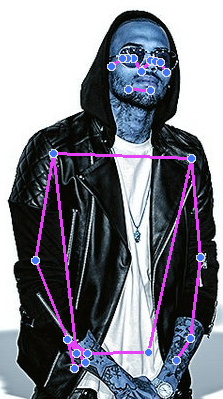

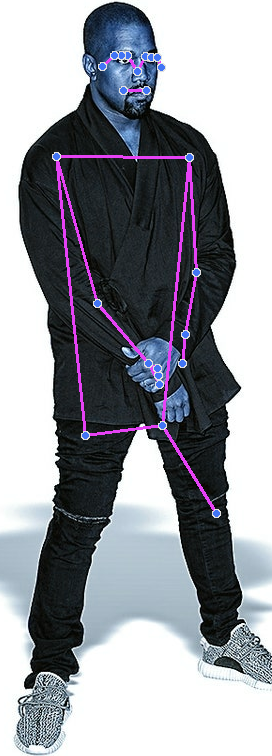

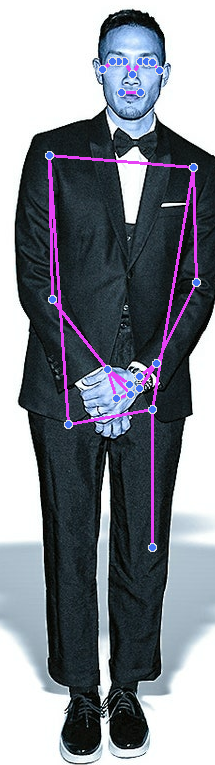

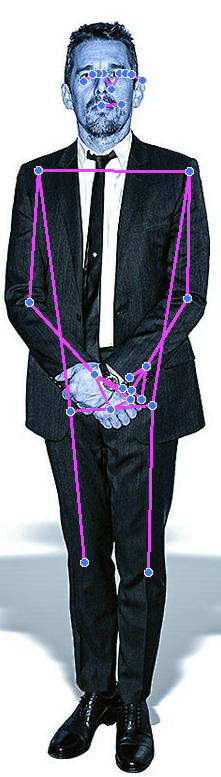

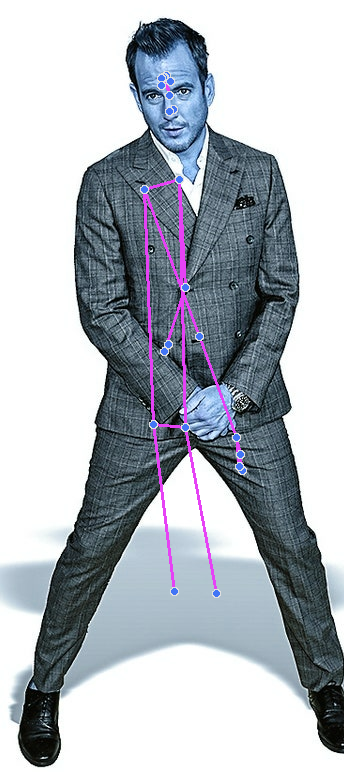

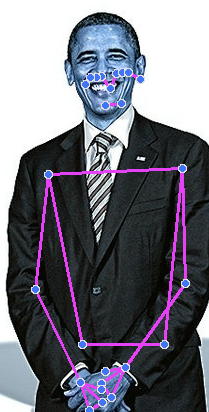

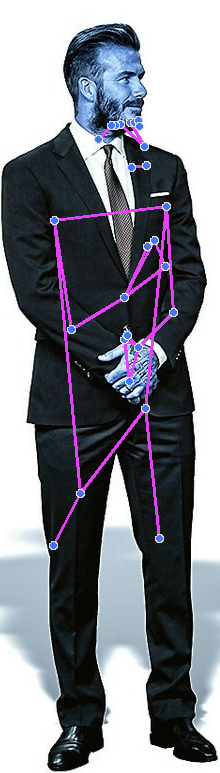

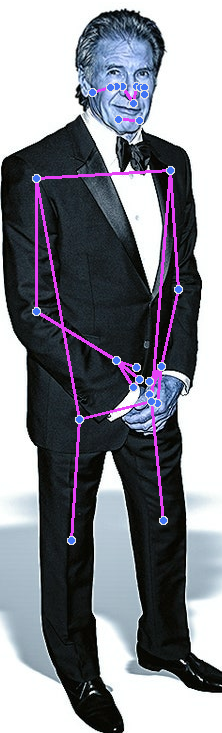

In [10]:
run_detector(detector, '/content/poses.jpg')

Found 100 objects.
Inference time:  5.772445201873779


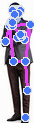

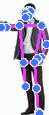

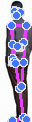

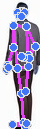

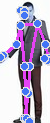

In [11]:
run_detector(detector, '/content/9ppl.jpg')

Found 100 objects.
Inference time:  3.327805757522583


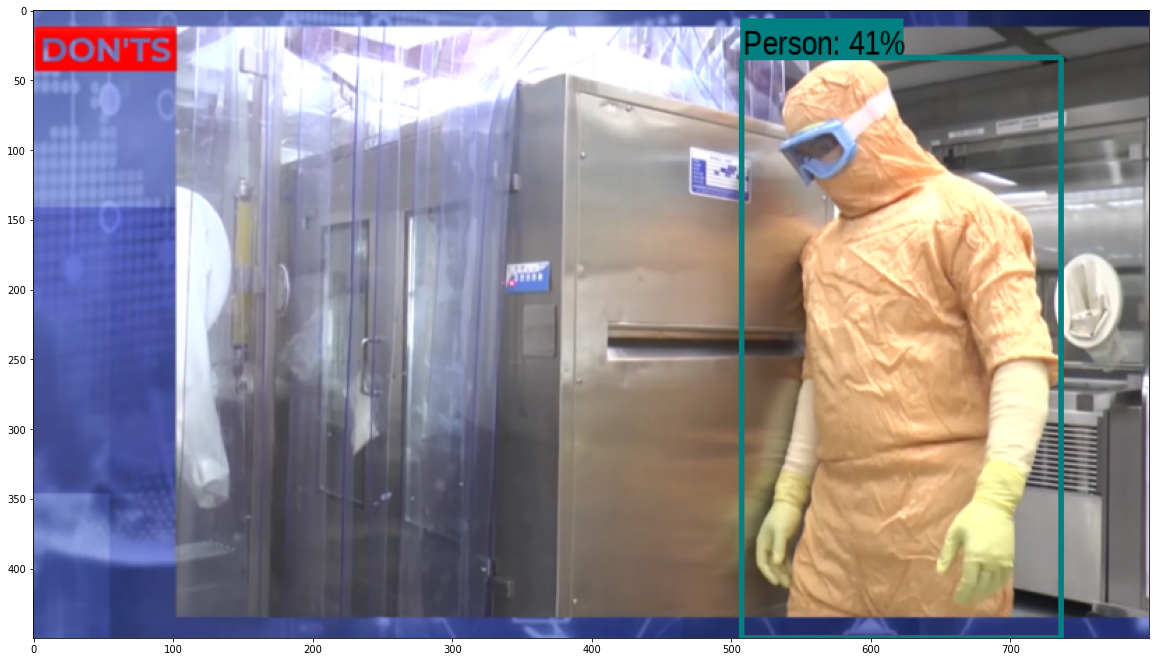

In [17]:
run_detector(detector, '/content/Screenshot (4).png')

Found 100 objects.
Inference time:  3.909635066986084


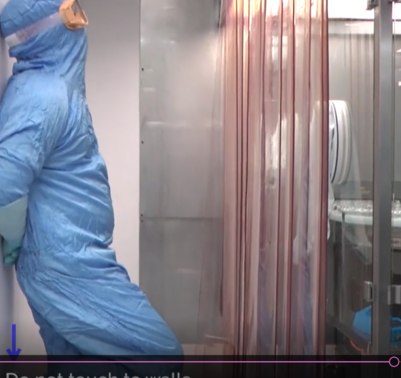

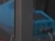

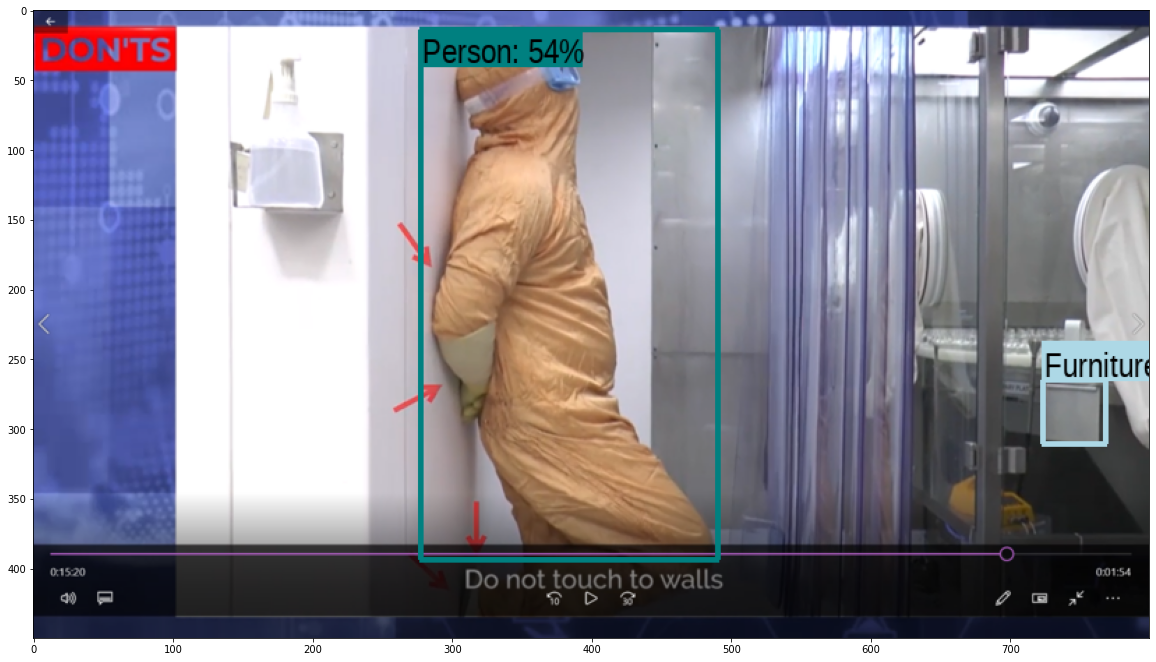

In [18]:
run_detector(detector, '/content/Screenshot (1).png')